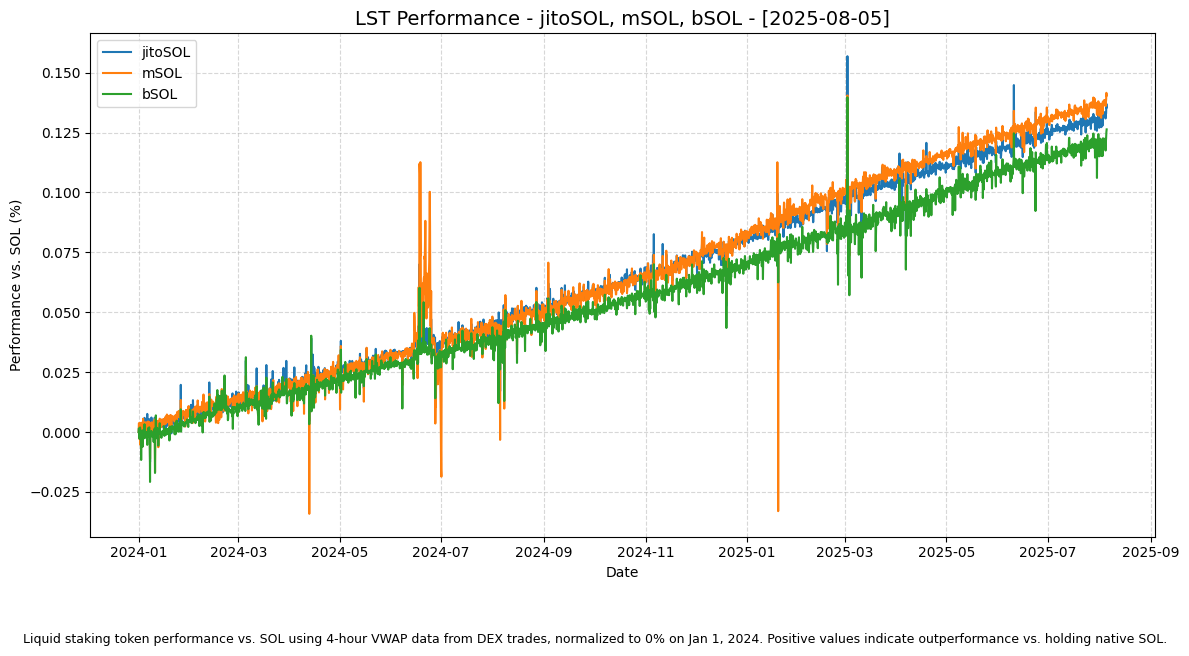

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("lst-performance.csv")
df['time_bucket'] = pd.to_datetime(df['time_bucket'], utc=True)

baseline_row = df.iloc[0]
baseline = baseline_row[['jitoSOL', 'mSOL', 'bSOL']].values

df['jitoSOL_norm'] = df['jitoSOL'] - baseline[0]
df['mSOL_norm'] = df['mSOL'] - baseline[1]
df['bSOL_norm'] = df['bSOL'] - baseline[2]

plt.figure(figsize=(12, 6))
plt.plot(df['time_bucket'], df['jitoSOL_norm'], label='jitoSOL')
plt.plot(df['time_bucket'], df['mSOL_norm'], label='mSOL')
plt.plot(df['time_bucket'], df['bSOL_norm'], label='bSOL')

plt.title("LST Performance - jitoSOL, mSOL, bSOL - [2025-08-05]", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Performance vs. SOL (%)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.figtext(
    0.5, -0.08,
    "Liquid staking token performance vs. SOL using 4-hour VWAP data from DEX trades, normalized to 0% on Jan 1, 2024. Positive values indicate outperformance vs. holding native SOL.",
    wrap=True, horizontalalignment='center', fontsize=9
)
plt.tight_layout()
plt.show()

In [15]:
from scipy.stats import kurtosis

latest_row = df.iloc[-1]
latest_date = df['time_bucket'].dt.strftime('%b. %-d, %Y').iloc[-1]
timeframe_label = f"Jan. 1, 2024 – {latest_date}"

def max_drawdown(series):
    running_max = series.cummax()
    drawdown = series - running_max
    return drawdown.min() * 100

def downside_percentile(series, percentile=5):
    return series.quantile(percentile / 100) * 100

summary = pd.DataFrame({
    "Timeframe": [timeframe_label] * 3,
    "Outperformance vs. SOL (%)": [
        latest_row["jitoSOL_norm"] * 100,
        latest_row["mSOL_norm"] * 100,
        latest_row["bSOL_norm"] * 100
    ],
    "Volatility (%)": [
        df["jitoSOL_norm"].std() * 100,
        df["mSOL_norm"].std() * 100,
        df["bSOL_norm"].std() * 100
    ],
    "Max Drawdown (%)": [
        max_drawdown(df["jitoSOL_norm"]),
        max_drawdown(df["mSOL_norm"]),
        max_drawdown(df["bSOL_norm"])
    ],
    "5th Percentile (%)": [
        downside_percentile(df["jitoSOL_norm"]),
        downside_percentile(df["mSOL_norm"]),
        downside_percentile(df["bSOL_norm"])
    ],
    "Excess Kurtosis": [
        kurtosis(df["jitoSOL_norm"], fisher=True),
        kurtosis(df["mSOL_norm"], fisher=True),
        kurtosis(df["bSOL_norm"], fisher=True)
    ]
}, index=["jitoSOL", "mSOL", "bSOL"])

summary = summary.round(4)

summary.style.set_properties(**{'text-align': 'left'}).set_table_styles([
    {"selector": "th", "props": [("text-align", "left")]}
])

,Timeframe,Outperformance vs. SOL (%),Volatility (%),Max Drawdown (%),5th Percentile (%),Excess Kurtosis
jitoSOL,"Jan. 1, 2024 – Aug. 5, 2025",13.543400,3.886700,-8.064100,0.687900,-1.222600
mSOL,"Jan. 1, 2024 – Aug. 5, 2025",14.043100,4.110400,-14.562800,0.725900,-1.244300
bSOL,"Jan. 1, 2024 – Aug. 5, 2025",12.630100,3.585200,-8.259000,0.391800,-1.144300


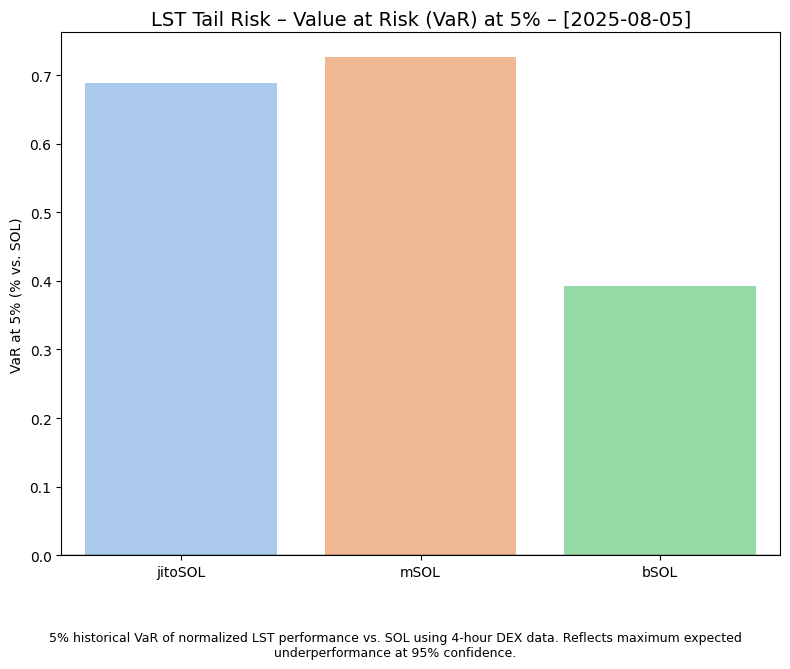

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

vars_5 = {
    "jitoSOL": downside_percentile(df["jitoSOL_norm"]),
    "mSOL": downside_percentile(df["mSOL_norm"]),
    "bSOL": downside_percentile(df["bSOL_norm"])
}

tokens = list(vars_5.keys())
values = [vars_5[token] for token in tokens]

plt.figure(figsize=(8, 6))
sns.barplot(x=tokens, y=values, palette="pastel")
plt.axhline(0, color="black", linewidth=1)

plt.title("LST Tail Risk – Value at Risk (VaR) at 5% – [2025-08-05]", fontsize=14)
plt.xlabel("")
plt.ylabel("VaR at 5% (% vs. SOL)")
plt.figtext(
    0.5, -0.1,
    "5% historical VaR of normalized LST performance vs. SOL using 4-hour DEX data. Reflects maximum expected underperformance at 95% confidence.",
    wrap=True, horizontalalignment='center', fontsize=9
)
plt.tight_layout()
plt.show()

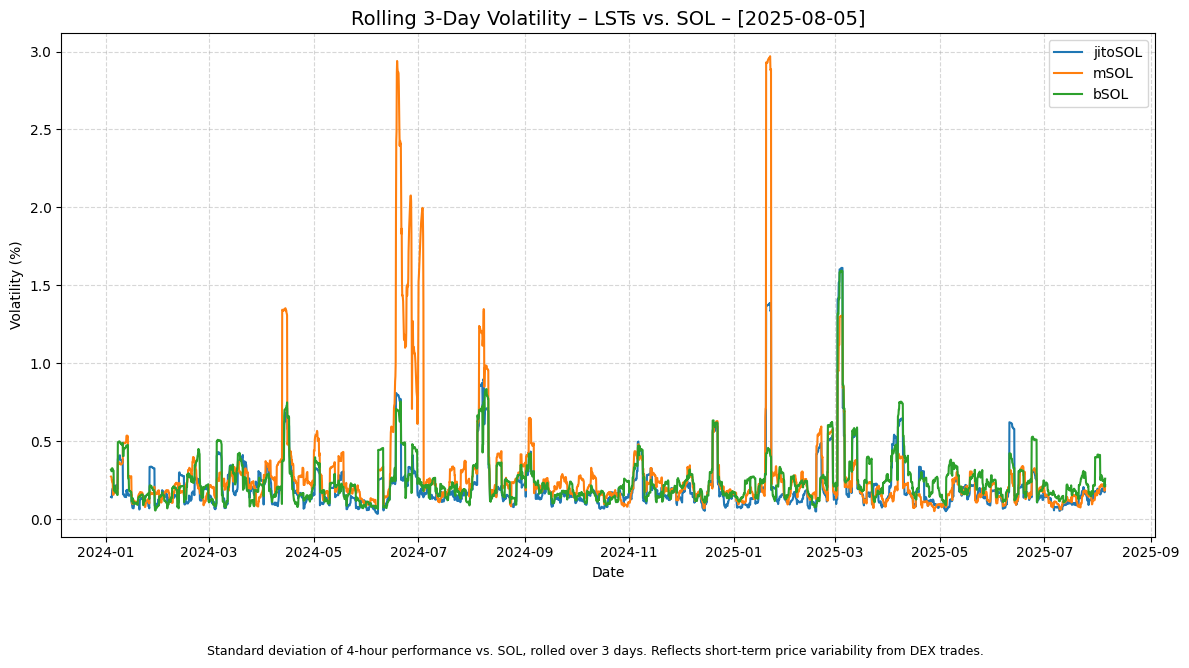

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
window = 18  # 3 days of 4-hour intervals

for token in ["jitoSOL_norm", "mSOL_norm", "bSOL_norm"]:
    rolling_vol = df[token].rolling(window=window).std() * 100
    plt.plot(df["time_bucket"], rolling_vol, label=token.replace("_norm", ""))

plt.title("Rolling 3-Day Volatility – LSTs vs. SOL – [2025-08-05]", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Volatility (%)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.figtext(
    0.5, -0.1,
    "Standard deviation of 4-hour performance vs. SOL, rolled over 3 days. Reflects short-term price variability from DEX trades.",
    wrap=True, horizontalalignment='center', fontsize=9
)
plt.show()

In [2]:
import pandas as pd
from scipy.stats import kurtosis
import matplotlib.pyplot as plt

df = pd.read_csv("lst-performance.csv")
df['time_bucket'] = pd.to_datetime(df['time_bucket'], utc=True)
baseline_row = df.iloc[0]
baseline = baseline_row[['jitoSOL', 'mSOL', 'bSOL']].values
df['jitoSOL_norm'] = df['jitoSOL'] - baseline[0]
df['mSOL_norm'] = df['mSOL'] - baseline[1]
df['bSOL_norm'] = df['bSOL'] - baseline[2]

window = 18  # 3 days of 4-hour intervals
df['jitoSOL_vol'] = df['jitoSOL_norm'].rolling(window=window).std() * 100
df['mSOL_vol'] = df['mSOL_norm'].rolling(window=window).std() * 100
df['bSOL_vol'] = df['bSOL_norm'].rolling(window=window).std() * 100

latest_date = df['time_bucket'].dt.strftime('%b. %-d, %Y').iloc[-1]
start_date = df['time_bucket'].dt.strftime('%b. %-d, %Y').iloc[0]
timeframe_label = f"{start_date} – {latest_date}"

def persistence_ratio(series):
   """Measures how consistently volatile a token is"""
   return (series > series.median()).mean() * 100

def volatility_clustering(series):
   """Measures volatility clustering using autocorrelation"""
   return series.autocorr()

summary = pd.DataFrame({
   "Timeframe": [timeframe_label] * 3,
   "Current Volatility (%)": [
       f"{df['jitoSOL_vol'].iloc[-1]:.3f}%",
       f"{df['mSOL_vol'].iloc[-1]:.3f}%",
       f"{df['bSOL_vol'].iloc[-1]:.3f}%"
   ],
   "Average Volatility (%)": [
       f"{df['jitoSOL_vol'].mean():.3f}%",
       f"{df['mSOL_vol'].mean():.3f}%",
       f"{df['bSOL_vol'].mean():.3f}%"
   ],
   "Peak Volatility (%)": [
       f"{df['jitoSOL_vol'].max():.3f}%",
       f"{df['mSOL_vol'].max():.3f}%",
       f"{df['bSOL_vol'].max():.3f}%"
   ],
   "Volatility of Volatility": [
       f"{df['jitoSOL_vol'].std():.3f}",
       f"{df['mSOL_vol'].std():.3f}",
       f"{df['bSOL_vol'].std():.3f}"
   ],
   "High Vol Persistence (%)": [
       f"{persistence_ratio(df['jitoSOL_vol']):.1f}%",
       f"{persistence_ratio(df['mSOL_vol']):.1f}%",
       f"{persistence_ratio(df['bSOL_vol']):.1f}%"
   ]
}, index=["jitoSOL", "mSOL", "bSOL"])

summary.style.set_properties(**{'text-align': 'left'}).set_table_styles([
   {"selector": "th", "props": [("text-align", "left")]}
])

,Timeframe,Current Volatility (%),Average Volatility (%),Peak Volatility (%),Volatility of Volatility,High Vol Persistence (%)
jitoSOL,"Jan. 1, 2024 – Aug. 5, 2025",0.219%,0.209%,1.612%,0.184,49.7%
mSOL,"Jan. 1, 2024 – Aug. 5, 2025",0.212%,0.293%,2.970%,0.362,49.7%
bSOL,"Jan. 1, 2024 – Aug. 5, 2025",0.260%,0.244%,1.595%,0.161,49.7%
